### Spatial transformer networks

Spatial Transformer Network (STN) allows a neural network to learn how to perform spatial transformations on the input image in order to enhance the geometric invariance of the model. For example, it can crop a region of interest, scale and correct the orientation of an image. It can be a useful mechanism because CNNs are not invariant to rotation and scale and more general affine transformations.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

plt.ion()

In [2]:
device = torch.device('cuda')

batch_size = 64
num_workers = 4
epoch = 10

In [102]:
train_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.RandomHorizontalFlip(),
                            transforms.Normalize((0.1307,), (0.3081,))
                                    ])
test_transform = train_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                                    ])

In [103]:
train_dataset = datasets.MNIST(root='../../../data/', train=True, \
                               download=True,
                               transform=train_transform)
test_dataset = datasets.MNIST(root='../../../data/', train=False, \
                              transform=test_transform)

In [104]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,\
                                          shuffle=True, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,\
                                          shuffle=True, num_workers=num_workers)


torch.Size([3, 242, 242])


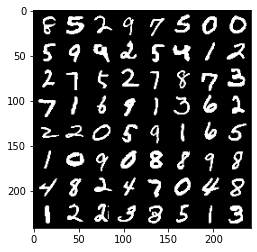

In [105]:
x_, y_ = next(iter(train_loader))
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
out = torchvision.utils.make_grid(x_)
print(out.size())
imshow(out)

#### Spatial transformer networks boils down to three main components :

* The localization network is a regular CNN which regresses the transformation parameters. The transformation is never learned explicitly from this dataset, instead the network learns automatically the spatial transformations that enhances the global accuracy.
* The grid generator generates a grid of coordinates in the input image corresponding to each pixel from the output image.
* The sampler uses the parameters of the transformation and applies it to the input image.

<img src='./imgs/arch.png'>

In [106]:
class TPS_SpatialTransformerNetwork(nn.Module):
    """ Rectification Network of RARE, namely TPS based STN """

    def __init__(self, F, I_size, I_r_size, I_channel_num=1):
        """ Based on RARE TPS
        input:
            batch_I: Batch Input Image [batch_size x I_channel_num x I_height x I_width]
            I_size : (height, width) of the input image I
            I_r_size : (height, width) of the rectified image I_r
            I_channel_num : the number of channels of the input image I
        output:
            batch_I_r: rectified image [batch_size x I_channel_num x I_r_height x I_r_width]
        """
        super(TPS_SpatialTransformerNetwork, self).__init__()
        self.F = F
        self.I_size = I_size
        self.I_r_size = I_r_size  # = (I_r_height, I_r_width)
        self.I_channel_num = I_channel_num
        self.LocalizationNetwork = LocalizationNetwork(self.F, self.I_channel_num)
        self.GridGenerator = GridGenerator(self.F, self.I_r_size)

    def forward(self, batch_I):
        batch_C_prime = self.LocalizationNetwork(batch_I)  # batch_size x K x 2
        build_P_prime = self.GridGenerator.build_P_prime(batch_C_prime)  # batch_size x n (= I_r_width x I_r_height) x 2
        build_P_prime_reshape = build_P_prime.reshape([build_P_prime.size(0), self.I_r_size[0], self.I_r_size[1], 2])
        
        if torch.__version__ > "1.2.0":
            batch_I_r = F.grid_sample(batch_I, build_P_prime_reshape, padding_mode='border', align_corners=True)
        else:
            batch_I_r = F.grid_sample(batch_I, build_P_prime_reshape, padding_mode='border')

        return batch_I_r

In [107]:
class LocalizationNetwork(nn.Module):
    """ Localization Network of RARE, which predicts C' (K x 2) from I (I_width x I_height) """

    def __init__(self, F, I_channel_num):
        super(LocalizationNetwork, self).__init__()
        self.F = F
        self.I_channel_num = I_channel_num
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=self.I_channel_num, out_channels=64, kernel_size=3, stride=1, padding=1,
                      bias=False), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # batch_size x 64 x I_height/2 x I_width/2
            nn.Conv2d(64, 128, 3, 1, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # batch_size x 128 x I_height/4 x I_width/4
            nn.Conv2d(128, 256, 3, 1, 1, bias=False), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # batch_size x 256 x I_height/8 x I_width/8
            nn.Conv2d(256, 512, 3, 1, 1, bias=False), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.AdaptiveAvgPool2d(1)  # batch_size x 512
        )

        self.localization_fc1 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(True))
        self.localization_fc2 = nn.Linear(256, self.F * 2)

        # Init fc2 in LocalizationNetwork
        self.localization_fc2.weight.data.fill_(0)
        """ see RARE paper Fig. 6 (a) """
        ctrl_pts_x = np.linspace(-1.0, 1.0, int(F / 2))
        ctrl_pts_y_top = np.linspace(0.0, -1.0, num=int(F / 2))
        ctrl_pts_y_bottom = np.linspace(1.0, 0.0, num=int(F / 2))
        ctrl_pts_top = np.stack([ctrl_pts_x, ctrl_pts_y_top], axis=1)
        ctrl_pts_bottom = np.stack([ctrl_pts_x, ctrl_pts_y_bottom], axis=1)
        initial_bias = np.concatenate([ctrl_pts_top, ctrl_pts_bottom], axis=0)
        self.localization_fc2.bias.data = torch.from_numpy(initial_bias).float().view(-1)

    def forward(self, batch_I):
        """
        input:     batch_I : Batch Input Image [batch_size x I_channel_num x I_height x I_width]
        output:    batch_C_prime : Predicted coordinates of fiducial points for input batch [batch_size x F x 2]
        """
        batch_size = batch_I.size(0)
        features = self.conv(batch_I).view(batch_size, -1)
        batch_C_prime = self.localization_fc2(self.localization_fc1(features)).view(batch_size, self.F, 2)
        return batch_C_prime

In [108]:
class GridGenerator(nn.Module):
    """ Grid Generator of RARE, which produces P_prime by multipling T with P """

    def __init__(self, F, I_r_size):
        """ Generate P_hat and inv_delta_C for later """
        super(GridGenerator, self).__init__()
        self.eps = 1e-6
        self.I_r_height, self.I_r_width = I_r_size
        self.F = F
        self.C = self._build_C(self.F)  # F x 2
        self.P = self._build_P(self.I_r_width, self.I_r_height)
        ## for multi-gpu, you need register buffer
        self.register_buffer("inv_delta_C", torch.tensor(self._build_inv_delta_C(self.F, self.C)).float())  # F+3 x F+3
        self.register_buffer("P_hat", torch.tensor(self._build_P_hat(self.F, self.C, self.P)).float())  # n x F+3
        ## for fine-tuning with different image width, you may use below instead of self.register_buffer
        #self.inv_delta_C = torch.tensor(self._build_inv_delta_C(self.F, self.C)).float().cuda()  # F+3 x F+3
        #self.P_hat = torch.tensor(self._build_P_hat(self.F, self.C, self.P)).float().cuda()  # n x F+3

    def _build_C(self, F):
        """ Return coordinates of fiducial points in I_r; C """
        ctrl_pts_x = np.linspace(-1.0, 1.0, int(F / 2))
        ctrl_pts_y_top = -1 * np.ones(int(F / 2))
        ctrl_pts_y_bottom = np.ones(int(F / 2))
        ctrl_pts_top = np.stack([ctrl_pts_x, ctrl_pts_y_top], axis=1)
        ctrl_pts_bottom = np.stack([ctrl_pts_x, ctrl_pts_y_bottom], axis=1)
        C = np.concatenate([ctrl_pts_top, ctrl_pts_bottom], axis=0)
        return C  # F x 2

    def _build_inv_delta_C(self, F, C):
        """ Return inv_delta_C which is needed to calculate T """
        hat_C = np.zeros((F, F), dtype=float)  # F x F
        for i in range(0, F):
            for j in range(i, F):
                r = np.linalg.norm(C[i] - C[j])
                hat_C[i, j] = r
                hat_C[j, i] = r
        np.fill_diagonal(hat_C, 1)
        hat_C = (hat_C ** 2) * np.log(hat_C)
        # print(C.shape, hat_C.shape)
        delta_C = np.concatenate(  # F+3 x F+3
            [
                np.concatenate([np.ones((F, 1)), C, hat_C], axis=1),  # F x F+3
                np.concatenate([np.zeros((2, 3)), np.transpose(C)], axis=1),  # 2 x F+3
                np.concatenate([np.zeros((1, 3)), np.ones((1, F))], axis=1)  # 1 x F+3
            ],
            axis=0
        )
        inv_delta_C = np.linalg.inv(delta_C)
        return inv_delta_C  # F+3 x F+3

    def _build_P(self, I_r_width, I_r_height):
        I_r_grid_x = (np.arange(-I_r_width, I_r_width, 2) + 1.0) / I_r_width  # self.I_r_width
        I_r_grid_y = (np.arange(-I_r_height, I_r_height, 2) + 1.0) / I_r_height  # self.I_r_height
        P = np.stack(  # self.I_r_width x self.I_r_height x 2
            np.meshgrid(I_r_grid_x, I_r_grid_y),
            axis=2
        )
        return P.reshape([-1, 2])  # n (= self.I_r_width x self.I_r_height) x 2

    def _build_P_hat(self, F, C, P):
        n = P.shape[0]  # n (= self.I_r_width x self.I_r_height)
        P_tile = np.tile(np.expand_dims(P, axis=1), (1, F, 1))  # n x 2 -> n x 1 x 2 -> n x F x 2
        C_tile = np.expand_dims(C, axis=0)  # 1 x F x 2
        P_diff = P_tile - C_tile  # n x F x 2
        rbf_norm = np.linalg.norm(P_diff, ord=2, axis=2, keepdims=False)  # n x F
        rbf = np.multiply(np.square(rbf_norm), np.log(rbf_norm + self.eps))  # n x F
        P_hat = np.concatenate([np.ones((n, 1)), P, rbf], axis=1)
        return P_hat  # n x F+3

    def build_P_prime(self, batch_C_prime):
        """ Generate Grid from batch_C_prime [batch_size x F x 2] """
        batch_size = batch_C_prime.size(0)
        batch_inv_delta_C = self.inv_delta_C.repeat(batch_size, 1, 1)
        batch_P_hat = self.P_hat.repeat(batch_size, 1, 1)
        batch_C_prime_with_zeros = torch.cat((batch_C_prime, torch.zeros(
            batch_size, 3, 2).float().to(device)), dim=1)  # batch_size x F+3 x 2
        batch_T = torch.bmm(batch_inv_delta_C, batch_C_prime_with_zeros)  # batch_size x F+3 x 2
        batch_P_prime = torch.bmm(batch_P_hat, batch_T)  # batch_size x n x 2
        return batch_P_prime  # batch_size x n x 2

In [127]:
class Model(nn.Module):
    '''
       input size: [batch_size, 1, 28, 28]
       output size: 10
    '''
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.transformation = TPS_SpatialTransformerNetwork(
                F=20, I_size=(28, 28), I_r_size=(28, 28), I_channel_num=1)
 

    def forward(self, x):
        # transform the input
        # x : input (1, 28, 28)
        self.x = self.transformation(x)

        # stn 통해 나온 결과는 str의 input과 동일한 size 
        # 즉 정규화된 이미지라고 생각하면 된다.

        # 여기서부터는 일반적인 classification을 위한 forward pass 와 동일
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

### forward 분석.

mnist input size = (28, 28,1) 가 stn(Spatial transformer network)에 입력되고 이 stn에서 transform된  출력의 tensor size는 input과 동일하다.

이 output이 아래와 같은 network를 통과하여 classification이 된다. 

```
(conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
(conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
(conv2_drop): Dropout2d (p=0.5)
(fc1): Linear (320 -> 50)
(fc2): Linear (50 -> 10)
```
여기서 가장 중요한 부분은 바로 stn이다.

theta = self.fc_loc(xs) 를 통과하면 아래와 같은 affine 변환을 위한 
parameter를 얻을 수 있다.

<img src='./imgs/formula.png'>

위에서 계산된 parameter를 아래 함수를 통과시키면 최종 결과를 얻을 수 있다.

```python
grid = F.affine_grid(theta, x.size())
x = F.grid_sample(x, grid)
```
affine_grid는 위에서 계산된 parameter theta(2x3)와 
input size (32x1x28x28)를 입력으로 받으면 
(32 x 28 x 28 x 2) size의 output Tensor를 생성하여 전달한다.

여기서 계산된 값을 affine_grid 2d flow를 통해 bilinear interpolation을 통해 output pixel값을 계산하여 최종 변환된 이미지를 가져온다.

위 두 함수에 특별히 학습할 parameter가 있는 것은 아니라 1개 함수로 만들어도 되지만 논문상의 용어와 맞추기 위해 구분해서 사용한 것 같다.

In [128]:
model = Model().to(device)

In [129]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [130]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        output = (model(data.to(device)))
        loss = F.nll_loss(output, target.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print('\rEpoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='')
        

In [131]:
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [132]:
train_loss, train_acc, test_loss, test_cc = [], [], [], []
for epoch in range(1, 21):
    train(epoch)
    test()

/home/wonchul/anaconda3/envs/wonchul/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 [29984/60000 (100%)]	Loss: 0.941847
Test set: Average loss: 0.3171, Accuracy: 9167/10000 (92%)

Epoch: 2 [29984/60000 (100%)]	Loss: 0.868872
Test set: Average loss: 0.1786, Accuracy: 9470/10000 (95%)

Epoch: 3 [29984/60000 (100%)]	Loss: 0.267648
Test set: Average loss: 0.1363, Accuracy: 9586/10000 (96%)

Epoch: 4 [29984/60000 (100%)]	Loss: 0.365845
Test set: Average loss: 0.1149, Accuracy: 9622/10000 (96%)

Epoch: 5 [29984/60000 (100%)]	Loss: 0.157408
Test set: Average loss: 0.0980, Accuracy: 9695/10000 (97%)

Epoch: 6 [29984/60000 (100%)]	Loss: 0.116825
Test set: Average loss: 0.0911, Accuracy: 9719/10000 (97%)

Epoch: 7 [29984/60000 (100%)]	Loss: 0.248626
Test set: Average loss: 0.0838, Accuracy: 9750/10000 (98%)

Epoch: 8 [29984/60000 (100%)]	Loss: 0.176352
Test set: Average loss: 0.0797, Accuracy: 9751/10000 (98%)

Epoch: 9 [29984/60000 (100%)]	Loss: 0.468051
Test set: Average loss: 0.0749, Accuracy: 9771/10000 (98%)

Epoch: 10 [29984/60000 (100%)]	Loss: 0.277118
Test set:

In [29]:
device

device(type='cuda')

In [ ]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')


# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()